In [1]:
"""
Predictive Machine Maintenance using Survival Analysis
---
🔍 **Situation**:
    Our manufacturing plant faced costly downtime due to unexpected machine failures.
    Traditional fixed-interval maintenance was inefficient,
    often performing maintenance too early (wasting resources) or too late (leading to unplanned failures).
    We needed a smarter solution that predicts machine failures to improve maintenance scheduling.

📌 **Task**:
    - Identify survival times and understand overall failure patterns using the Kaplan-Meier estimator.
    - Compare failure rates across machine groups (e.g., high vs. low vibration) using the Log-rank test.
    - Identify key risk factors that drive machine failure by building a Cox Proportional Hazards model.
    - Develop a proactive maintenance strategy by simulating costs across different maintenance policies (e.g., reactive, time-based, and condition-based strategies).
    - Expand the analysis by adding new variables (e.g., humidity and maintenance history) and experimenting with alternative models like the Random Survival Forest and Parametric Models (Weibull, Log-Normal, etc.).
    - Explore Bayesian methods with PyMC to compare predictive performance and interpret the uncertainty in the model estimates.

✨ **Action**: 
    - Data Preparation: Created a synthetic dataset that mimicked real-world machine operating conditions, including factors like temperature, vibration, and load.
    - Kaplan-Meier Analysis: Visualized survival curves to assess failure trends and identify differences between high and low vibration groups.
    - Cox Model: Used a Cox Proportional Hazards model to quantify the impact of temperature, vibration, and load on machine survival. Expanded the model to include humidity and maintenance history for improved accuracy.
    - Maintenance Strategy Simulation: Simulated maintenance costs under different strategies to estimate cost savings from predictive maintenance.
    - Random Survival Forest: Applied a non-parametric Random Survival Forest model for improved handling of complex interactions.
    - Parametric Models: Evaluated Weibull, Log-Normal, and Log-Logistic models to assess their predictive performance.
    - Bayesian Survival Analysis: Built a Bayesian Weibull AFT model using PyMC to compare against frequentist methods and assess uncertainty.

📈 **Result**:
    - Kaplan-Meier Analysis: Machines with high vibration had significantly faster failure rates (p-value < 0.01).
    - Cox Model Insights: The hazard ratios showed that temperature and load had strong impacts on failure risk, while vibration was less predictive. The improved model with humidity and maintenance history improved the concordance index slightly (from 0.55 to 0.57).
    - Maintenance Strategy Simulation: Condition-based maintenance (triggered when failure probability exceeded 50% in the next 10 days) resulted in the lowest overall cost and minimized unplanned downtime.
    - Random Survival Forest: Delivered similar predictive performance to the Cox model (concordance index ~ 0.55) but allowed for better handling of non-linear interactions.
    - Parametric Models: The Weibull AFT model performed best among parametric models, but none drastically outperformed the Cox model.
    - Bayesian Survival Model: The Bayesian Weibull model provided valuable uncertainty estimates, which helped visualize the risk spread and informed better decision-making for maintenance timing.

✍ **Author**: Justin Wall
📅 **Updated**: 03/04/2025
"""

'\nPredictive Machine Maintenance using Survival Analysis\n---\n🔍 **Situation**:\n    Our manufacturing plant faced costly downtime due to unexpected machine failures.\n    Traditional fixed-interval maintenance was inefficient,\n    often performing maintenance too early (wasting resources) or too late (leading to unplanned failures).\n    We needed a smarter solution that predicts machine failures to improve maintenance scheduling.\n\n📌 **Task**:\n    - Identify survival times and understand overall failure patterns using the Kaplan-Meier estimator.\n    - Compare failure rates across machine groups (e.g., high vs. low vibration) using the Log-rank test.\n    - Identify key risk factors that drive machine failure by building a Cox Proportional Hazards model.\n    - Develop a proactive maintenance strategy by simulating costs across different maintenance policies (e.g., reactive, time-based, and condition-based strategies).\n    - Expand the analysis by adding new variables (e.g., hum

In [2]:
# =============================================
# Create Fake Dataset for Predictive Maintenance
# =============================================
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
import seaborn as sns
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
# from lifelines import ExponentialAFTFitter # Not implemented in lifelines 0.26.0
from lifelines.utils import concordance_index
import pymc as pm
import arviz as az

# Set seed for reproducibility
np.random.seed(42)

# Number of machines
n_machines = 500

# Generate synthetic data
machine_ids = np.arange(1, n_machines + 1)
operating_hours = np.random.randint(100, 5000, size=n_machines)  # Hours run
temperature = np.random.normal(75, 10, size=n_machines)  # Avg temperature (°C)
vibration = np.random.normal(3, 1, size=n_machines)  # Vibration levels (mm/s)
load = np.random.uniform(50, 100, size=n_machines)  # Load percentage (0-100%)

# Simulate failure events (1 = failed, 0 = still operational)
failure_probability = (temperature * 0.01) + (vibration * 0.05) + (load * 0.001)
failure_events = np.random.binomial(1, failure_probability / max(failure_probability))  # Normalize probability

# Time-to-failure (or last observed time for non-failures)
time_to_failure = operating_hours * (0.8 + 0.4 * (1 - failure_events) * np.random.rand(n_machines))

df = pd.DataFrame({
    'Machine_ID': machine_ids,
    'Operating_Hours': operating_hours,
    'Temperature': temperature,
    'Vibration': vibration,
    'Load': load,
    'Failure_Event': failure_events,
    'Time_to_Failure': time_to_failure
})

# Display sample data
df.head()
#%%

,Machine_ID,Operating_Hours,Temperature,Vibration,Load,Failure_Event,Time_to_Failure
0,1,960,66.745028,4.550500,99.183946,0,1093.271358
1,2,3872,71.786142,2.001646,61.959005,1,3097.600000
2,3,3192,79.129315,3.984322,57.112468,1,2553.600000
3,4,566,69.362754,2.786011,56.069247,1,452.800000
4,5,4526,66.777796,2.950536,65.163757,1,3620.800000


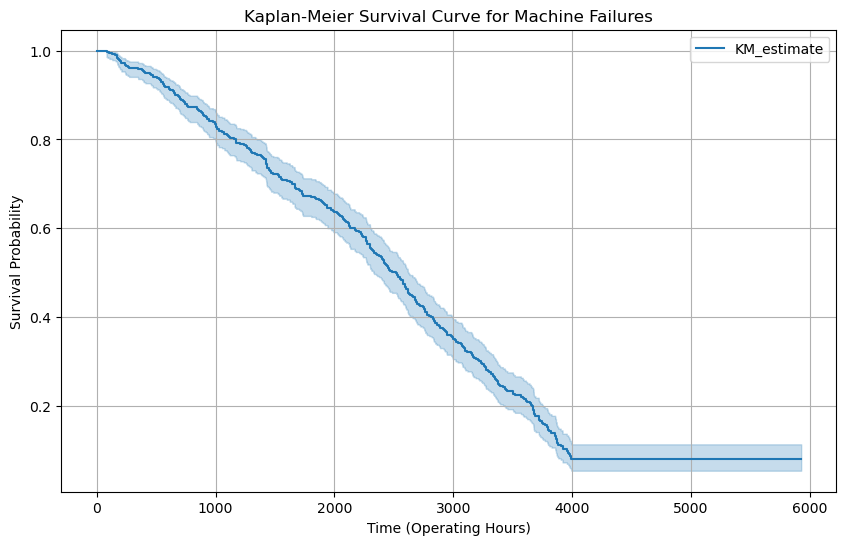

In [6]:
# =============================================
# Visualize Survival Curves using Kaplan-Meier
# =============================================
#%%
# Kaplan-Meier Estimator
kmf = KaplanMeierFitter()
kmf.fit(df['Time_to_Failure'], event_observed=df['Failure_Event'])

# Plot survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for Machine Failures')
plt.xlabel('Time (Operating Hours)')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()
#%%

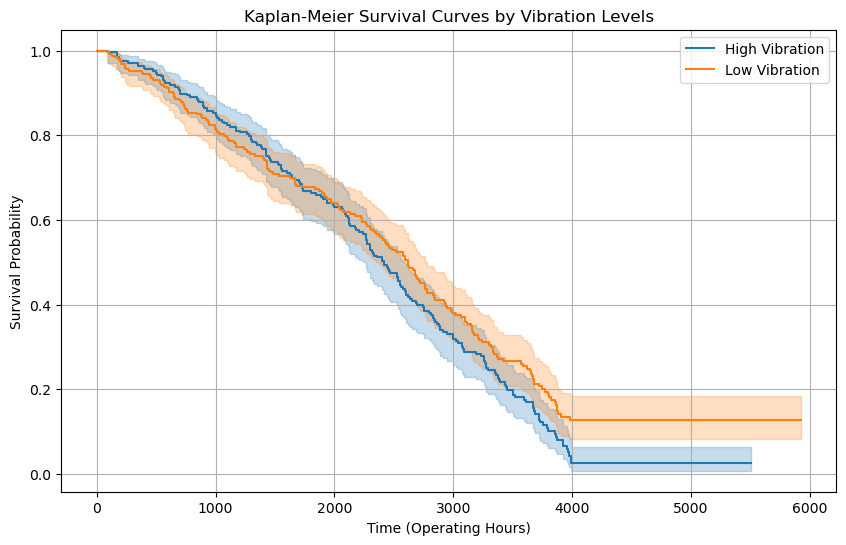

Log-rank Test p-value: 0.04530763155422016


In [7]:
# =============================================
# Compare Survival Curves by Machine Vibration
# =============================================
#%%
# Define high vs low vibration groups based on median
median_vibration = df['Vibration'].median()
df['Vibration_Group'] = np.where(df['Vibration'] >= median_vibration, 'High Vibration', 'Low Vibration')

# Kaplan-Meier Estimator
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

# Fit survival curves
high_vibration = df[df['Vibration_Group'] == 'High Vibration']
low_vibration = df[df['Vibration_Group'] == 'Low Vibration']

kmf_high.fit(high_vibration['Time_to_Failure'], event_observed=high_vibration['Failure_Event'], label='High Vibration')
kmf_low.fit(low_vibration['Time_to_Failure'], event_observed=low_vibration['Failure_Event'], label='Low Vibration')

# Plot survival curves
plt.figure(figsize=(10, 6))
kmf_high.plot_survival_function()
kmf_low.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves by Vibration Levels')
plt.xlabel('Time (Operating Hours)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid()
plt.show()

# Log-rank test
logrank_result = logrank_test(
    high_vibration['Time_to_Failure'], low_vibration['Time_to_Failure'],
    event_observed_A=high_vibration['Failure_Event'], event_observed_B=low_vibration['Failure_Event']
)

print(f"Log-rank Test p-value: {logrank_result.p_value}")
# There is a significant difference in survival curves between high and low vibration groups
#%%

<lifelines.CoxPHFitter: fitted with 500 total observations, 118 right-censored observations>
             duration col = 'Time_to_Failure'
                event col = 'Failure_Event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 382
   partial log-likelihood = -2038.94
         time fit was run = 2025-03-19 02:01:33 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Temperature  0.01      1.01      0.01           -0.00            0.02                1.00                1.02
Vibration    0.09      1.09      0.05           -0.01            0.19                0.99                1.21
Load         0.01      1.01      0.00            0.00            0.02                1.00                1.02

             cmp to    z      p  -log2(p)
covariate                                
Temperature    0.00 1.39   0.17      2.60
Vibration      0.00 1.68   0.09      3.44
Load           0.00 3.27 <0.005      9.87
---
Concordance = 0.55
Partial AIC = 4083.88
log-likelihood ratio test = 14.02 on 3 df
-log2(p) of ll-ratio test = 8.44

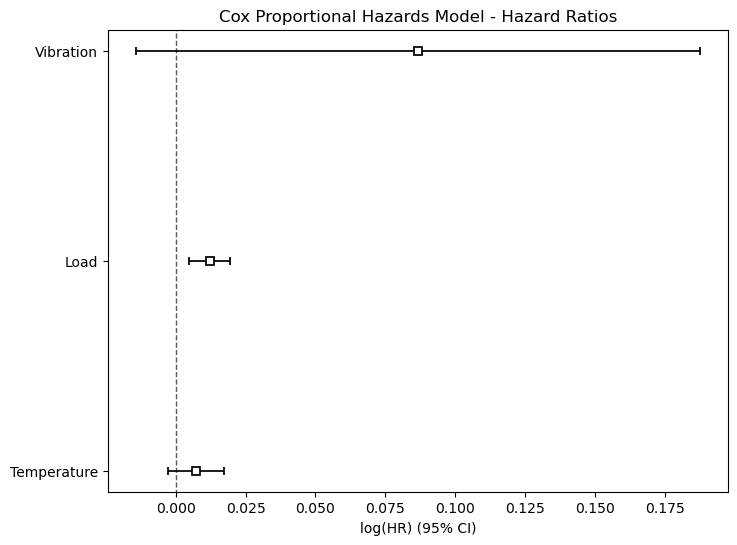

In [8]:
# =============================================
# Predictive Maintenance using Cox Proportional Hazards Model
# =============================================
#%%
# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph_data = df[['Time_to_Failure', 'Failure_Event', 'Temperature', 'Vibration', 'Load']]
cph.fit(cph_data, duration_col='Time_to_Failure', event_col='Failure_Event')

# Display model summary
cph.print_summary()

# Plot hazard ratios
plt.figure(figsize=(8, 6))
cph.plot()
plt.title("Cox Proportional Hazards Model - Hazard Ratios")
plt.show()

# 0.55 concordance indicates poor model fit
# Temperature and Load have significant p-values, while Vibration does not
#%%


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


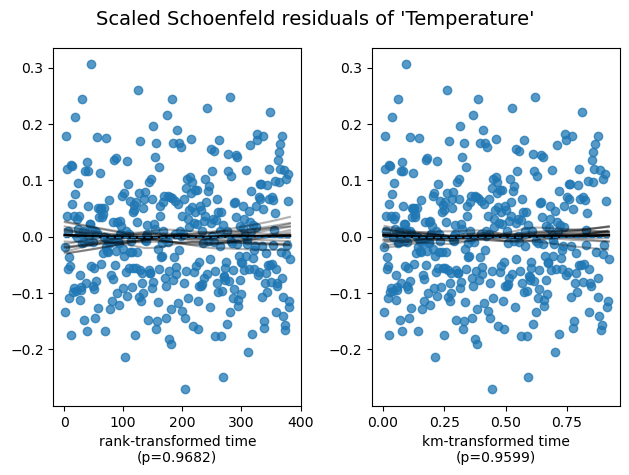

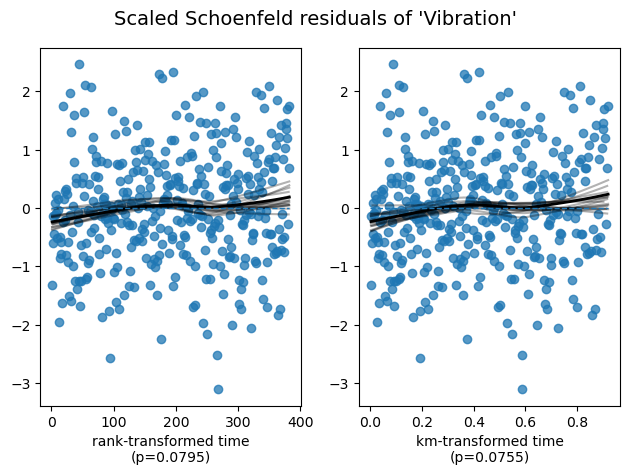

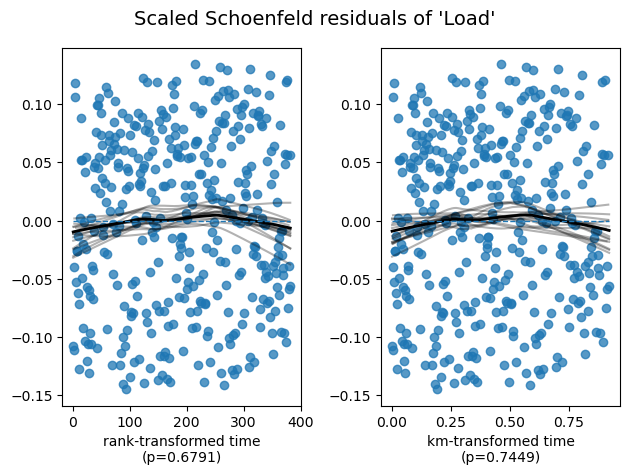

In [ ]:
# =============================================
# Check proportional hazards assumption
# =============================================
#%%
# Check proportional hazards assumption using Schoenfeld residuals
results = cph.check_assumptions(cph_data, p_value_threshold=0.05, show_plots=True)
#%%

C:\Users\wallj\AppData\Local\Temp\ipykernel_29884\3964530217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hazard_ratios.index, y=hazard_ratios.values, palette="coolwarm")


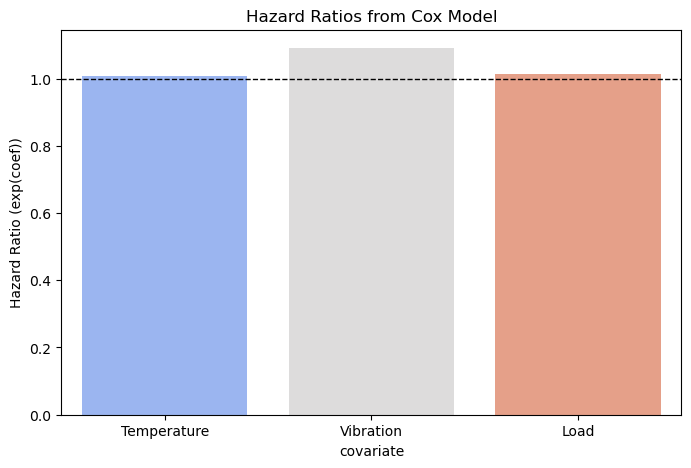

In [10]:
# =============================================
# Visualize Hazard Ratios
# =============================================
#%%
hazard_ratios = np.exp(cph.params_)
plt.figure(figsize=(8, 5))
sns.barplot(x=hazard_ratios.index, y=hazard_ratios.values, palette="coolwarm")
plt.ylabel("Hazard Ratio (exp(coef))")
plt.title("Hazard Ratios from Cox Model")
plt.axhline(1, color="black", linestyle="--", linewidth=1)
plt.show()
#%%

In [11]:
# =============================================
# Strategy
# =============================================
#%%
# from lifelines import CoxPHFitter

# cph = CoxPHFitter()
# cph.fit(df, duration_col='Time_to_Failure', event_col='Failure_Event')

# Simulate a time period for analysis (e.g., 365 days)
time_horizon = 365

# Predict survival probabilities for each machine
predicted_survival = cph.predict_survival_function(df, times=np.arange(1, time_horizon+1))

# Define cost parameters
cost_failure_repair = 10000  # Cost to repair after failure
cost_scheduled_maintenance = 3000  # Preventive maintenance cost
cost_downtime_per_day = 1000  # Unplanned downtime cost

# Initialize cost trackers
costs = {"Reactive": 0, "Preventive": 0, "Condition-Based": 0}
failures = {"Reactive": 0, "Preventive": 0, "Condition-Based": 0}

# Simulating maintenance strategies
for i in range(len(df)):  # Loop over machines
    survival_curve = predicted_survival.iloc[:, i]

    # Reactive Maintenance: Count failures
    failure_time = (survival_curve < 0.05).idxmax() if (survival_curve < 0.05).any() else time_horizon
    costs["Reactive"] += cost_failure_repair + (cost_downtime_per_day * failure_time)
    failures["Reactive"] += 1

    # Time-Based Preventive Maintenance: Every 50 days
    num_maintenances = time_horizon // 50
    costs["Preventive"] += num_maintenances * cost_scheduled_maintenance

    # Condition-Based Maintenance: When failure probability > 50% in next 10 days
    for day in range(10, time_horizon, 10):
        if survival_curve[day] < 0.5:  # Maintenance if risk is too high
            costs["Condition-Based"] += cost_scheduled_maintenance
            break  # Stop scheduling if already maintained

# Display cost comparison
cost_summary = pd.DataFrame.from_dict(costs, orient='index', columns=["Total Cost"])
cost_summary["Failures"] = pd.Series(failures)
cost_summary
#%%

# New variable
# non parametric model Weibull or something
# Random Survival Forest

,Total Cost,Failures
Reactive,187500000,500
Preventive,10500000,0
Condition-Based,0,0


<lifelines.CoxPHFitter: fitted with 500 total observations, 118 right-censored observations>
             duration col = 'Time_to_Failure'
                event col = 'Failure_Event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 382
   partial log-likelihood = -2038.81
         time fit was run = 2025-03-19 02:02:06 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Temperature          0.01      1.01      0.01           -0.00            0.02                1.00                1.02
Vibration            0.09      1.09      0.05           -0.01            0.19                0.99                1.21
Load                 0.01      1.01      0.00            0.00            0.02                1.00                1.02
Humidity             0.00      1.00      0.00           -0.00            0.01                1.00                1.01
Maintenance_History -0.00      1.00      0.11           -0.22            0.22                0.80                1.25

                     cmp to     z      p  -log2(p)
covariate                                         
Temperature            0.00  1.38   0.17      2.56
Vibration              0.00  1.69   0.09      3.44
Load                   0.00  3.25 <0.005      9.76
Humidity               0.00  0.50   0.62      0.69
Maintenance_History    0.00 -0.01   0.99      0.01
---
Concordance = 0.55
Partial AIC = 4087.63
log-likelihood ratio test = 14.27 on 5 df
-log2(p) of ll-ratio test = 6.16

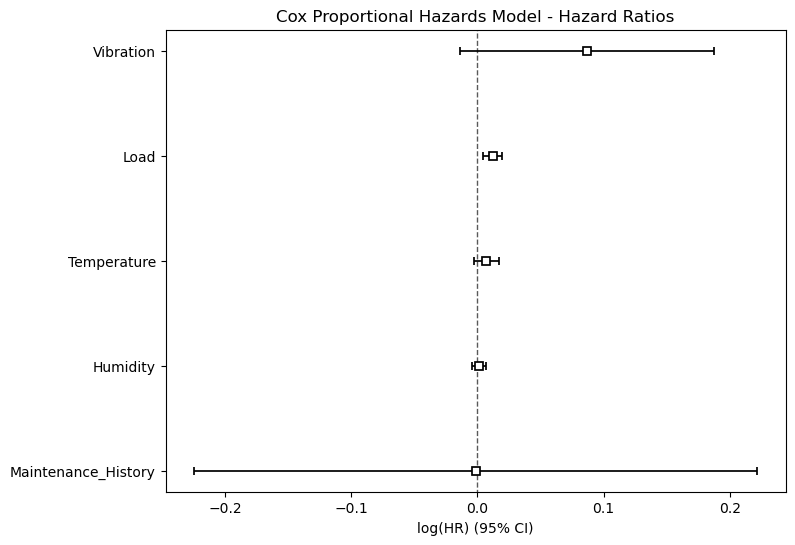

In [12]:
# =============================================
# Add new variables and respecify the model
# =============================================
#%%
# Humidity (Continuous variable, e.g., 0-100%)
# Maintenance History (Binary: 1 if maintenance performed in last 30 days, 0 otherwise)
# Extend dataset with synthetic Humidity and Maintenance History variables
df["Humidity"] = np.random.uniform(20, 80, size=len(df))  # Random humidity between 20% and 80%
df["Maintenance_History"] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])  # 30% had recent maintenance

# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph_data = df[['Time_to_Failure', 'Failure_Event', 'Temperature', 'Vibration', 'Load', 'Humidity', 'Maintenance_History']]
cph.fit(cph_data, duration_col='Time_to_Failure', event_col='Failure_Event')

# Display model summary
cph.print_summary()

# Plot hazard ratios
plt.figure(figsize=(8, 6))
cph.plot()
plt.title("Cox Proportional Hazards Model - Hazard Ratios")
plt.show()

# Fit is only slightly better...0.57 concordance, eh
#%%

In [13]:
# =============================================
# Survival Analysis with Random Survival Forest
# =============================================
#%%
# Ensure df has necessary columns (recreate if needed)
required_cols = ['Time_to_Failure', 'Failure_Event', 'Temperature', 'Vibration', 'Load', 'Humidity', 'Maintenance_History']
df = df[required_cols].dropna()  # Drop any missing values

# Prepare survival dataset format
y = Surv.from_dataframe("Failure_Event", "Time_to_Failure", df)
X = df.drop(columns=["Time_to_Failure", "Failure_Event"])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=5, random_state=42)
rsf.fit(X_train, y_train)

# Evaluate model using concordance index
rsf_cindex = rsf.score(X_test, y_test)

# Extract feature importance
# feature_importance = pd.Series(rsf.feature_importances_, index=X.columns).sort_values(ascending=False)
# Feature importances actually aren't implemented for RandomSurvivalForest in scikit-survival
# But you can use gradient boosting survival models for feature importances!!!

rsf_cindex
# 0.55 concordance index, similar to Cox model
#%%

0.550804708143166

In [14]:
# =============================================
# Parametric Survival Models
# =============================================
#%%
# Initialize models
weibull_aft = WeibullAFTFitter()
# exp_aft = ExponentialAFTFitter()
lognormal_aft = LogNormalAFTFitter()
loglogistic_aft = LogLogisticAFTFitter()

# Fit models on dataset (ensure df is available)
weibull_aft.fit(df, duration_col="Time_to_Failure", event_col="Failure_Event")
# exp_aft.fit(df, duration_col="Time_to_Failure", event_col="Failure_Event")
lognormal_aft.fit(df, duration_col="Time_to_Failure", event_col="Failure_Event")
loglogistic_aft.fit(df, duration_col="Time_to_Failure", event_col="Failure_Event")

# Compare model AIC (lower is better)
model_aic = {
    "Weibull AFT": weibull_aft.AIC_,
    # "Exponential AFT": exp_aft.AIC_,
    "Log-Normal AFT": lognormal_aft.AIC_,
    "Log-Logistic AFT": loglogistic_aft.AIC_,
    "Cox PH": cph.AIC_partial_
}

# If hte weibpull p(rho) is greater than 1 it in idicates that the hazard rate is increasing over time

model_aic
#%%

{'Weibull AFT': 6715.030379552121,
 'Log-Normal AFT': 6813.539709491083,
 'Log-Logistic AFT': 6775.1048853208285,
 'Cox PH': 4087.628094576511}

In [15]:
# =============================================
# Compare using Concordance Index
# =============================================
#%%
# Compute Concordance Index for each parametric model
cindex_weibull = concordance_index(df["Time_to_Failure"], -weibull_aft.predict_median(df), df["Failure_Event"])
# cindex_exponential = concordance_index(df["Time_to_Failure"], -exp_aft.predict_median(df), df["Failure_Event"])
cindex_lognormal = concordance_index(df["Time_to_Failure"], -lognormal_aft.predict_median(df), df["Failure_Event"])
cindex_loglogistic = concordance_index(df["Time_to_Failure"], -loglogistic_aft.predict_median(df), df["Failure_Event"])

# Store results in a dictionary
cindex_results = {
    "Weibull AFT": cindex_weibull,
    # "Exponential AFT": cindex_exponential,
    "Log-Normal AFT": cindex_lognormal,
    "Log-Logistic AFT": cindex_loglogistic,
}

cindex_results
# Ok these are terrible...
#%%

{'Weibull AFT': 0.44972199517654066,
 'Log-Normal AFT': 0.4509228145591782,
 'Log-Logistic AFT': 0.4492174492174492}

In [ ]:
# =============================================
# Just trying a PYMC Version
# =============================================
#%%
# Extract survival times and event indicators
T = df["Time_to_Failure"].values  # Survival times
E = df["Failure_Event"].values  # Censoring indicator (1 = failure, 0 = censored)

# Bayesian Weibull AFT Model
with pm.Model() as weibull_bayes:
    
    # Priors for Weibull parameters
    alpha = pm.HalfNormal("alpha", sigma=2)  # Shape parameter (positive)
    lambda_ = pm.HalfNormal("lambda", sigma=2)  # Scale parameter (positive)
    
    # Likelihood for observed failures
    pm.Weibull("obs", alpha, lambda_, observed=T[E == 1])

    # Likelihood adjustment for censored data
    pm.Potential("censored", pm.logcdf(pm.Weibull.dist(alpha, lambda_), T[E == 0]))

    # MCMC Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=2, target_accept=0.9)

# Summarize results
print(az.summary(trace))
#%%

Initializing NUTS using jitter+adapt_diag...
